<a href="https://colab.research.google.com/github/svandergoote/LGBIO2060-2021/blob/main/LGBIO2060_TP2_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBIO2060 Exercice session 2

#Bayesian inference of a binary hidden state 

__Authors:__ Simon Vandergooten and Clémence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy


In this second exercise session, we will introduce the basic principle of bayesian inference in order to produce an estimate of a binary hidden state and take decisions based on this estimate and the associated uncertainty.  

After this session you should be able to:
* Use probability distribution to represent hidden states 
* Combine new information with your prior knowledge
* Combine the possible loss (or gain) for making a decision with your probabilistic knowledge



#Introduction and context 

The world is full of latent variables that you cannot observe directly. Then you need to estimate these variables from the prior knowledge you have about it and some noisy measurements. 

Bayesian inference is a method based on the Bayes theorem used to  combine prior knowledge and noisy measurements to infer an unknown state. The estimate obtained with the Bayes theorem is associated to some uncertainty (how confident we are that our estimate is true), and helps making a decision. 

We will first handle binary states. It means that X can be either A or B. Next week, we will extend this theorem to continuous states, i.e. X can take any value between $-\infty \to \infty$. 

Today, you're going to the lake, hoping to catch some fishes. At the dock, you have to decide if you are going to fish on the left side or on the right side. To make this decision, you would want to know which side the school of fish is on to maximise your chances to catch a fish. As you cannot see directly where they are (the fishes's state is the latent variable that you're trying to estimate), you will have to base your decision on your previous knowledge (for example, you know that most of the time, fishes are on the left) and on a measurement (a fisherperson is on the right side of the deck and has caught a fish). Additionaly, by fishing on the wrong side of the deck, you'll have a higher probability of getting a sunburn, which is not desirable. 
<Figure>
  <img alt='Gone fishing' align='centered' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/Gone%20fishing.PNG>

</Figure>



# Setup  


In [ ]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, transforms, gridspec
from scipy.optimize import fsolve
from collections import namedtuple
from scipy import stats
from scipy.special import erf

In [ ]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import GridspecLayout, HBox, VBox, FloatSlider, Layout, ToggleButtons
from ipywidgets import interactive, interactive_output, Checkbox, Select
from IPython.display import clear_output
#%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [ ]:
# @title Plotting Functions

def plot_prior_likelihood_posterior(prior, likelihood, posterior):

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space +  added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey = ax_prior)

    rect_colormap = plt.cm.Blues

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0, 0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1, 0]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='Greens')


    # Probabilities plot details
    # ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
    #              ylabel = 'state (s)', title = "Prior p(s)")
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m (left) | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details

    ax_posterior.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Posterior p(s | m)')
    ax_posterior.xaxis.set_ticks_position('bottom')
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)


    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{posterior[i,j]:.2f}"
        ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i, 0]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')


def plot_prior_likelihood(ps, p_a_s1, p_a_s0, measurement):
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    assert 0.0 <= ps <= 1.0
    prior = np.asarray([ps, 1 - ps])
    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.9
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(12, 4))

    rect_prior = [left, bottom, small_width, height]
    rect_likelihood = [left_space , bottom , width, height]
    rect_posterior = [left_space + width + small_padding, bottom , small_width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_likelihood = fig.add_axes(rect_likelihood, sharey=ax_prior)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_prior)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    # ax_posterior.matshow(posterior, vmin=0., vmax=1., cmap='')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{posterior[i,j]:.2f}"
    #     ax_posterior.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    return fig


from matplotlib import colors
def plot_utility(ps):
    prior = np.asarray([ps, 1 - ps])

    utility = np.array([[2, -3], [-2, 1]])

    expected = prior @ utility

    # definitions for the axes
    left, width = 0.05, 0.16
    bottom, height = 0.05, 0.9
    padding = 0.02
    small_width = 0.1
    left_space = left + small_width + padding
    added_space = padding + width

    fig = plt.figure(figsize=(17, 3))

    rect_prior = [left, bottom, small_width, height]
    rect_utility = [left + added_space , bottom , width, height]
    rect_expected = [left + 2* added_space, bottom , width, height]

    ax_prior = fig.add_axes(rect_prior)
    ax_utility = fig.add_axes(rect_utility, sharey=ax_prior)
    ax_expected = fig.add_axes(rect_expected)

    rect_colormap = plt.cm.Blues

    # Data of plots
    ax_prior.barh(0, prior[0], facecolor = rect_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = rect_colormap(prior[1]))
    ax_utility.matshow(utility, cmap='cool')
    norm = colors.Normalize(vmin=-3, vmax=3)
    ax_expected.bar(0, expected[0], facecolor = rect_colormap(norm(expected[0])))
    ax_expected.bar(1, expected[1], facecolor = rect_colormap(norm(expected[1])))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], xticks = [], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Probability of state")
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'action (a)',
                   title = 'Utility')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected utility plot details
    ax_expected.set(title = 'Expected utility', ylim = [-3, 3],
                    xticks = [0, 1], xticklabels = ['left', 'right'],
                    xlabel = 'action (a)',
                    yticks = [])
    ax_expected.xaxis.set_ticks_position('bottom')
    ax_expected.spines['left'].set_visible(False)
    ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)

    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, 2.5, c, va='center', ha='center', color='black')

    return fig


def plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0, measurement):
    assert 0.0 <= ps <= 1.0
    assert 0.0 <= p_a_s1 <= 1.0
    assert 0.0 <= p_a_s0 <= 1.0
    prior = np.asarray([ps, 1 - ps])
    likelihood = np.asarray([[p_a_s1, 1-p_a_s1],[p_a_s0, 1-p_a_s0]])
    utility = np.array([[2.0, -3.0], [-2.0, 1.0]])
    # expected = np.zeros_like(utility)

    if measurement == "Fish":
        posterior = likelihood[:, 0] * prior
    else:
        posterior = (likelihood[:, 1] * prior).reshape(-1)
    posterior /= np.sum(posterior)
    # expected[:, 0] = utility[:, 0] * posterior
    # expected[:, 1] = utility[:, 1] * posterior
    expected = posterior @ utility

    # definitions for the axes
    left, width = 0.05, 0.3
    bottom, height = 0.05, 0.3
    padding = 0.12
    small_width = 0.2
    left_space = left + small_width + padding
    small_padding = 0.05

    fig = plt.figure(figsize=(10, 9))

    rect_prior = [left, bottom + height + padding, small_width, height]
    rect_likelihood = [left_space , bottom + height + padding , width, height]
    rect_posterior = [left_space + width + small_padding, bottom + height + padding , small_width, height]

    rect_utility = [padding, bottom, width, height]
    rect_expected = [padding + width + padding + left, bottom, width, height]

    ax_likelihood = fig.add_axes(rect_likelihood)
    ax_prior = fig.add_axes(rect_prior, sharey=ax_likelihood)
    ax_posterior = fig.add_axes(rect_posterior, sharey=ax_likelihood)
    ax_utility = fig.add_axes(rect_utility)
    ax_expected = fig.add_axes(rect_expected)

    prior_colormap = plt.cm.Blues
    posterior_colormap = plt.cm.Greens
    expected_colormap = plt.cm.Wistia

    # Show posterior probs and marginals
    ax_prior.barh(0, prior[0], facecolor = prior_colormap(prior[0]))
    ax_prior.barh(1, prior[1], facecolor = prior_colormap(prior[1]))
    ax_likelihood.matshow(likelihood, vmin=0., vmax=1., cmap='Reds')
    ax_posterior.barh(0, posterior[0], facecolor = posterior_colormap(posterior[0]))
    ax_posterior.barh(1, posterior[1], facecolor = posterior_colormap(posterior[1]))
    ax_utility.matshow(utility, vmin=0., vmax=1., cmap='cool')
    # ax_expected.matshow(expected, vmin=0., vmax=1., cmap='Wistia')
    ax_expected.bar(0, expected[0], facecolor = expected_colormap(expected[0]))
    ax_expected.bar(1, expected[1], facecolor = expected_colormap(expected[1]))

    # Probabilities plot details
    ax_prior.set(xlim = [1, 0], yticks = [0, 1], yticklabels = ['left', 'right'],
                 title = "Prior p(s)", xticks = [])
    ax_prior.yaxis.tick_right()
    ax_prior.spines['left'].set_visible(False)
    ax_prior.spines['bottom'].set_visible(False)

    # Likelihood plot details
    ax_likelihood.set(xticks = [0, 1], xticklabels = ['fish', 'no fish'],
                  yticks = [0, 1], yticklabels = ['left', 'right'],
                   ylabel = 'state (s)', xlabel = 'measurement (m)',
                   title = 'Likelihood p(m | s)')
    ax_likelihood.xaxis.set_ticks_position('bottom')
    ax_likelihood.spines['left'].set_visible(False)
    ax_likelihood.spines['bottom'].set_visible(False)

    # Posterior plot details
    ax_posterior.set(xlim = [0, 1], xticks = [], yticks = [0, 1],
                     yticklabels = ['left', 'right'], title = "Posterior p(s | m)")
    ax_posterior.spines['left'].set_visible(False)
    ax_posterior.spines['bottom'].set_visible(False)

    # Utility plot details
    ax_utility.set(xticks = [0, 1], xticklabels = ['left', 'right'],
                   xlabel = 'action (a)', yticks = [0, 1], yticklabels = ['left', 'right'],
                   title = 'Utility', ylabel = 'state (s)')
    ax_utility.xaxis.set_ticks_position('bottom')
    ax_utility.spines['left'].set_visible(False)
    ax_utility.spines['bottom'].set_visible(False)

    # Expected Utility plot details
    ax_expected.set(ylim = [-2, 2], xticks = [0, 1], xticklabels = ['left', 'right'],
                 xlabel = 'action (a)', title = 'Expected utility', yticks=[])
    # ax_expected.axis('off')
    ax_expected.spines['left'].set_visible(False)
    # ax_expected.set(xticks = [0, 1], xticklabels = ['left', 'right'],
    #                 xlabel = 'action (a)',
    #                title = 'Expected utility')
    # ax_expected.xaxis.set_ticks_position('bottom')
    # ax_expected.spines['left'].set_visible(False)
    # ax_expected.spines['bottom'].set_visible(False)

    # show values
    ind = np.arange(2)
    x,y = np.meshgrid(ind,ind)
    for i in ind:
        v = posterior[i]
        c = f"{v:.2f}"
        ax_posterior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{likelihood[i,j]:.2f}"
        ax_likelihood.text(j,i, c, va='center', ha='center', color='black')
    for i,j in zip(x.flatten(), y.flatten()):
        c = f"{utility[i,j]:.2f}"
        ax_utility.text(j,i, c, va='center', ha='center', color='black')
    # for i,j in zip(x.flatten(), y.flatten()):
    #     c = f"{expected[i,j]:.2f}"
    #     ax_expected.text(j,i, c, va='center', ha='center', color='black')
    for i in ind:
        v = prior[i]
        c = f"{v:.2f}"
        ax_prior.text(v+0.2, i, c, va='center', ha='center', color='black')
    for i in ind:
        v = expected[i]
        c = f"{v:.2f}"
        ax_expected.text(i, v, c, va='center', ha='center', color='black')

    return fig

In [ ]:
# @title Helper Functions

def simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample,
                                     verbose=True):
  """Simulate and plot a SPRT for a fixed amount of time given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    stop_time (int): Number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
    """

  evidence_history_list = []
  if verbose:
    print("#Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_fixedtime(mu, sigma, stop_time)
    if verbose:
      print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Accumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                  "stopping rule")

  plt.show(fig)

  
def log_likelihood_ratio(Mvec, p0, p1):
  """Given a sequence(vector) of observed data, calculate the log of
  likelihood ratio of p1 and p0

  Args:
    Mvec (numpy vector):           A vector of scalar measurements
    p0 (Gaussian random variable): A normal random variable with `logpdf'
                                    method
    p1 (Gaussian random variable): A normal random variable with `logpdf`
                                    method

  Returns:
    llvec: a vector of log likelihood ratios for each input data point
  """
  return p1.logpdf(Mvec) - p0.logpdf(Mvec)

#Part 1: Bayesian inference with one measurement

The bayes theorem is the fundamental element of bayesian inference. It states that:  
\begin{equation}
 P(s | m) = \frac{P(m | s) P(s)}{P(m)}  \tag{1} \end{equation}

 where $s$ is the state and $m$ the measurement. 

$p(s|m)$ is called the **posterior** (updated knowledge). It represents your belief after gaining information with the measurement. For example it is the probability that the school of fish is on the right given that a fisherperson caught a fish on the left side of the dock.

$p(m|s)$ is called the **likelihood**. It described of much information you gain from your measurement. For example, when fishing on the left it is the probability to catch a fish, given that the school is on the left. 

$p(s)$ is the **prior knowledge**. It describes what you know about the hidden state, before taking a measurement. For example, you know that there is 70% of chance that the fishes are on the left.

$p(m)$ describes all possible measurements. It is a **normalization term**, also called the marginal likelihood or the evidence. 

##Likelihood

Let's think a bit about the likelihood. Suppose that you observe a fisherperson **fishing at the left side of the dock**. Either he caught a fish or he didn't. Let's say that you have 50% chance of catching a fish if you are on the correct side of the dock, but only 10% if your are at the wrong side of the dock. 

1) Please figure out each of the following:
- probability of catching a fish given that the school of fish is on the left side, $P(m = \textrm{catch fish} | s = \textrm{left} )$
- probability of not catching a fish given that the school of fish is on the left side, $P(m = \textrm{no fish} | s = \textrm{left})$
- probability of catching a fish given that the school of fish is on the right side, $P(m = \textrm{catch  fish} | s = \textrm{right})$
- probability of not catching a fish given that the school of fish is on the right side, $P(m = \textrm{no fish} | s = \textrm{right})$

Sum up these answers in a numpy array as described in the next cell. 

2) If the fisherperson catches a fish, which side would you guess the school is on?

3) If the fisherperson does not catch a fish, which side would you guess the school is on? 



In [ ]:
###likelihood (ndarray): i x j array with likelihood probabilities where i is number of state options, j is number of measurement options

likelihood = np.array([[0.5, 0.5],
                       [0.1, 0.9]]) #first row is s = left, second row is s = right; first column is fish, second is no fish

2) If the fisherperson catches a fish, you would guess the school of fish is on the left side. This is because the probability of catching a fish given that the school is on the left side (0.5) is higher than the probability given that the school is on the right side (0.1).

3)  If the fisherperson does not catch a fish, you would guess the school of fish is on the right side. This is because the probability of not catching a fish given that the school is on the right side (0.9) is higher than the probability given that the school is on the right side (0.5). 

##Prior

In the previous exercise, you tried to guess where the school of fish was based on the measurement you took (watching someone fish). You did this by choosing the state that maximized the probability of the measurement. In other words, you estimated the state by maximizing the likelihood (recall the MLE you've encounter in the first tutorial).

But, what if you had been going to this dock for years and you knew that the fish were almost always on the left side? This should probably affect how you make your estimate -- you would rely less on the single new measurement and more on your prior knowledge. This is the fundemental idea behind Bayesian inference.


In [ ]:
#Run this cell
# p(s = left) = 0.3; p(s = right) = 0.7

prior = np.array([0.3, 0.7]).reshape((2, 1)) # first row is s = left, second row is s = right

##Normalization (marginal likelihood)

When we normalize to find the posterior, we need to determine the marginal likelihood - or evidence - for the measurement we observed. As we do not have direct access to the normalization term $p(m)$, we need to compute it through the marginalization process. As stated in Equation 2-4, you can either use joint probabilities or conditional probabilities 

$$p(m) = \sum_s p(m, s) \tag{2} $$ 


$$ p(m,s) = p(m|s)p(s) \tag{3} $$

\\

$$p(m) = \sum_s p(m | s) p(s) \tag{4} $$


Please complete the following math problem to further practice thinking through probabilities:

1. Calculate the marginal likelihood of the fish being caught, $P(m = \textrm{fish})$, considering the likelihoods and prior defined sooner (you are still observing a person fishing on the **left** side of the dock). 


Normalizing by this $p(m)$ means that our posterior is a complete probability distribution that sums or integrates to 1 appropriately. 
For many complicated cases, like those we might be using to model behavioral or brain inferences, the normalization term can be intractable or extremely complex to calculate. We can be careful to choose probability distributions were we can analytically calculate the posterior probability or numerical approximation is reliable. Better yet, we sometimes don't need to bother with this normalization! The normalization term, $p(m)$, is the probability of the measurement. This does not depend on state so is essentially a constant we can often ignore. We can compare the unnormalized posterior distribution values for different states because how they relate to each other is unchanged when divided by the same constant. 

##Posterior

You are now ready to put everything together ! 
Our prior is $p(s = \textrm{left}) = 0.3$ and $p(s = \textrm{right}) = 0.7$. We also learned that the chance of catching a fish given they fish on the same side as the school was 50%. Otherwise, it was 10%. We observe a person fishing on the left side.

First, calculate on paper the posterior probability that... (don't forget to normalize)

1. The school is on the left if the fisherperson catches a fish: $p(s = \textrm{left} | m = \textrm{fish})$
2. The school is on the right if the fisherperson does not catch a fish: $p(s = \textrm{right} | m = \textrm{no fish})$

Let's implement our above math to be able to compute posteriors for different priors and likelihoods. You are asked to fill a function taking the prior and likelihoods as argument and return the posteriors.  We want our full posterior to take the same 2 by 2 form. Make sure the outputs match your math answers!

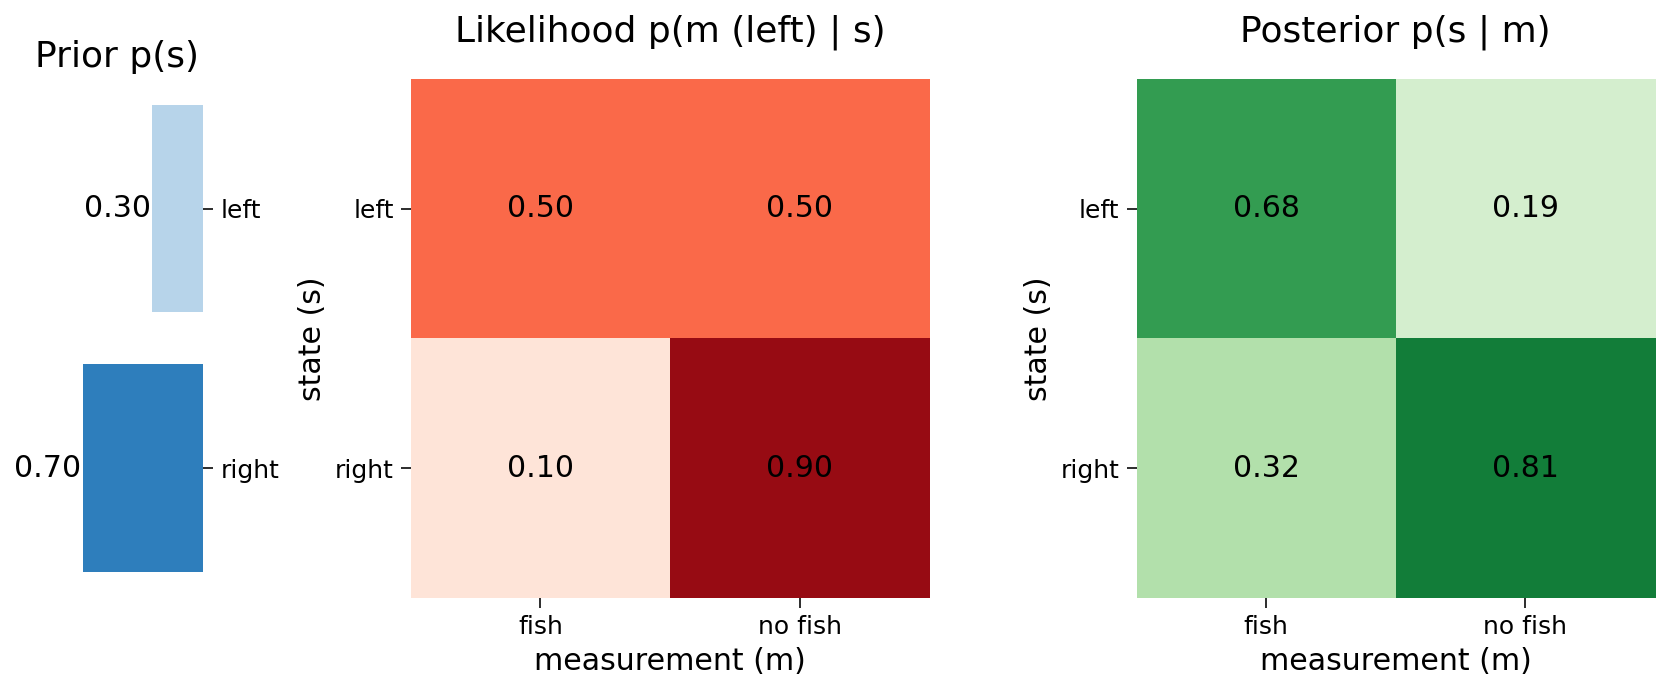

In [ ]:
def compute_posterior(likelihood, prior):
  """ Use Bayes' Rule to compute posterior from likelihood and prior

  Args:
    likelihood (ndarray): i x j array with likelihood probabilities where i is
                    number of state options, j is number of measurement options
    prior (ndarray): i x 1 array with prior probability of each state

  Returns:
    ndarray: i x j array with posterior probabilities where i is
            number of state options, j is number of measurement options

  """

  ############################
  ###### YOUR CODE HERE ######
  ############################
  posterior = likelihood * prior
  p_m = np.sum(posterior, axis=0) #We marginalize by taking the sum over S
  posterior /= p_m
  return posterior

# prior and likelihood defined above

# Compute posterior
posterior = compute_posterior(likelihood, prior)

# Visualize
plot_prior_likelihood_posterior(prior, likelihood, posterior)


*Example output:*

<img alt='Solution hint' align='left' width=1665.0 height=674.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D1_BayesianDecisions/static/W3D1_Tutorial1_Solution_1a2cc907_0.png>



## Interactive Demo: What affects the posterior?

Now that we can understand the implementation of *Bayes rule*, let's vary the parameters of the prior and likelihood to see how changing the prior and likelihood affect the posterior. 

In the demo below, you can change the prior by playing with the slider for $p( s = left)$. You can also change the likelihood by changing the probability of catching a fish given that the school is on the left and the probability of catching a fish given that the school is on the right. The fisherperson you are observing is fishing on the left.
 

1.   Keeping the likelihood constant, when does the prior have the strongest influence over the posterior? Meaning, when does the posterior look most like the prior no matter whether a fish was caught or not?
2.   What happens if the likelihoods for catching a fish are similar when you fish on the correct or incorrect side?
3.  Set the prior probability of the state = left to 0.6 and play with the likelihood. When does the likelihood exert the most influence over the posterior?

1)  The prior exerts a strong influence over the posterior when it is very informative: when the probability of the school being on one side or the other. If the prior that the fish are on the left side is very high (like 0.9), the posterior probability of the state being left is high regardless of the measurement.

2)  When the likelihoods are similar, the information gained from catching a fish or not is less informative. Intuitively, if you were about as likely to catch a fish regardless of the true location, then catching a fish doesn't tell you very much! The differences between the likelihoods is a way of thinking about how much information we can gain. You can try to figure out why, as we've given you all the clues...

3)  Similarly to the prior, the likelihood exerts the most influence when it is informative: when catching a fish tells you a lot of information about which state is likely. For example, if the probability of the fisherperson catching a fish if he is fishing on the right side and the school is on the left is 0 (p fish | s = left) = 0 and the probability of catching a fish if the school is on the right is 1, the prior does not affect the posterior at all. The measurement tells you the hidden state completely.

In [ ]:
# @markdown Execute this cell to enable the widget
style = {'description_width': 'initial'}

ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01)
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style = style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style = style, layout=Layout(width='370px'))
# observed_widget = widgets.Checkbox(value=False, description='Observed fish (m)',
#                                  disabled=False, indent=False,
#                                  layout=Layout(display="flex", justify_content="center"))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])
widget_out = interactive_output(plot_prior_likelihood,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_plot(ps,p_a_s1,p_a_s0,m_right):
#     fig = plot_prior_likelihood(ps,p_a_s1,p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None

Output()

We now can use this new, complete probability distribution for any future inference or decisions we like! In fact, as we will see in the second part of the tutorial, we can use it as a new prior! Finally, we often call this probability distribution our beliefs over the hidden states, to emphasize that it is our subjective knowlege about the hidden state.

##Utility and decision

Now that you have some belief about the location of the fishes, you need to decide where to fish. It may seem obvious - you could just fish on the side where the probability of the fish being is higher. Unfortunately, decisions and actions are always a little more complicated. Deciding where to fish may be influenced by more than just the probability of the school of fish being there. In our example, it is more difficult to fish on the right side because there is a motor boat at this side of the lake. Additionally, fishing on the wrong side, where there aren’t many fish, is likely to lead to you spending your afternoon not catching fish and therefore getting a sunburn. The consequences of the action you take is based on the true (but hidden) state of the world **and** the action you choose ! 

We quantify gains and losses numerically using a **utility** function $U(s,a)$, which describes the consequences of your actions: how much value you gain (or if negative, lose) given the state of the world ($s$) and the action you take ($a$). In our example, our utility can be summarized as:

|  U(s,a)   | a = left   | a = right  |
| ----------------- |------------|------------|
| s = Left          | +2         | -3         |
| s = right         | -2         | +1         |


If you want to know what to expect from taking the action of fishing on one side or the other, you need to calculate the expected utility by weighing the utilities with the probability of that state occuring. This allows us to choose actions by taking probabilities of events into account: we don't care if the outcome of an action-state pair is a loss if the probability of that state is very low. We can formalize this as:

$$ \text{Expected utility of action a} = \sum_{s}U(s,a)P(s) $$

Implement a function `expected_utility(utility, posterior)` to compute the expected utility associated with an action, given the probability of a state. Then, for each of these scenarios, determine which action would have been correct.

1.  You just arrived at the dock for the first time and have no sense of where the fish might be. Which side would you choose to fish on given our utility values?
2.  You think that the probability of the school being on the left side is very low (0.1) and correspondingly high on the right side (0.9). Which side would you choose to fish on given our utility values?
3. What probability distribution of the states would give you equal expected utility ? 

Note that we can use our posterior probability as the probability of the state $P(s)$. 

In [ ]:
def expected_utility(utility, state_proba):
  """ Compute expected utility from utility and probability distribution of the state

  Args:
    utility (ndarray): i x j array with utility where i is
                    number of state options, j is number of action options
    state_proba (ndarray): i x 1 array with probability of each state

  Returns:
    ndarray: i array with the expected utility where i is
            number of action options

  """
  ############################
  ###### YOUR CODE HERE ######
  ############################
  expected_utility = utility * state_proba
  expected_utility = np.sum(expected_utility, axis=0)
  return expected_utility

utility = np.array([[2, -3],
                    [-2, 1]])
state_proba = np.array([[3/8],
                        [5/8]])
print(expected_utility(utility, state_proba))


[-0.5 -0.5]


1) If you have no idea then P(s=left) = P(s=right) = 0.5. You compute the following expected utility : 0 and -1. Based on this result you should decide to fish on the left side.

2)You obtain -1.6 and 0.6 then you decide to fish on the right.

3)You obtain -0.5 and -0.5 for P(s=left)=3/8 and P(s=right)=5/8

## Interactive Demo: What is more important, the probabilities or the utilities?

Play a bit with the following widget to gain some intuitions on how each element that goes into a Bayesian decision comes together. Remember, the common assumption in neuroscience, psychology, economics, ecology, etc. is that we (humans and animals) are tying to maximize our expected utility. 

In [ ]:
# @markdown Execute this cell to enable the widget
# style = {'description_width': 'initial'}

ps_widget = widgets.FloatSlider(0.3, description='p(s = left)',
                                min=0.01, max=0.99, step=0.01, layout=Layout(width='300px'))
p_a_s1_widget = widgets.FloatSlider(0.5, description='p(fish on left | state = left)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))
p_a_s0_widget = widgets.FloatSlider(0.1, description='p(fish on left | state = right)',
                                    min=0.01, max=0.99, step=0.01, style=style, layout=Layout(width='370px'))

observed_widget = ToggleButtons(options=['Fish', 'No Fish'],
    description='Observation (m) on the left:', disabled=False, button_style='',
    layout=Layout(width='auto', display="flex"),
    style={'description_width': 'initial'}
)

widget_ui = VBox([ps_widget,
                  HBox([p_a_s1_widget, p_a_s0_widget]),
                  observed_widget])

widget_out = interactive_output(plot_prior_likelihood_utility,
                                {'ps': ps_widget,
                                'p_a_s1': p_a_s1_widget,
                                'p_a_s0': p_a_s0_widget,
                                'measurement': observed_widget})
display(widget_ui, widget_out)

# @widgets.interact(
#     ps=ps_widget,
#     p_a_s1=p_a_s1_widget,
#     p_a_s0=p_a_s0_widget,
#     m_right=observed_widget
# )
# def make_prior_likelihood_utility_plot(ps, p_a_s1, p_a_s0,m_right):
#     fig = plot_prior_likelihood_utility(ps, p_a_s1, p_a_s0,m_right)
#     plt.show(fig)
#     plt.close(fig)
#     return None

Output()

#Part 2: Integration of several measurements (Drift diffusion model)

In this second part, we learn how to integrate evidence over time. We will still assume that the world state is _binary_ ($\pm 1$) and _constant_ over time, but allow for multiple observations over time. 


**Sequential Probability Ratio Test**

The Sequential Probability Ratio Test is a likelihood ratio test for determining which of two hypotheses is more likely given some measurements, taken from time 1 up to time t  ($m_{1:t}$), 

In practice the likelihood ratio is the ratio of the likelihood of all these measurements given the state is +1 to the likelihood of the measurements given the state is -1. For some practical reasons, we are taking the log of the ratio. 

\begin{align*}
L_T &= log\frac{p(m_{1:t}|s=+1)}{p(m_{1:t}|s=-1)}
\end{align*}

The SPRT states that if $L_T$ is positive, then the state $s=+1$ is more likely than $s=-1$! 


Since our data (measurements) are independent and identically distributed, the probability of all measurements given the state equals the product of the separate probabilities of each measurement given the state:
$$ p(m_{1:t}|s) = \prod_{t=1}^T p(m_t | s) $$

 We can substitute this in and use log properties to convert to a sum.

\begin{align*}
L_T &= log\frac{p(m_{1:t}|s=+1)}{p(m_{1:t}|s=-1)}\\
&= log\frac{\prod_{t=1}^Tp(m_{t}|s=+1)}{\prod_{t=1}^Tp(m_{t}|s=-1)}\\
&= \sum_{t=1}^T log\frac{p(m_{t}|s=+1)}{p(m_{t}|s=-1)}\\
&= \sum_{t=1}^T \Delta_t
\end{align*}

with $\Delta_t = log\frac{p(m_{t}|s=+1)}{p(m_{t}|s=-1)}$, the ratio at each time step.  

To get the full log likelihood ratio, we are summing up the log likelihood ratios at each time step. The log likelihood ratio at a time step ($L_T$) will equal the ratio at the previous time step ($L_{T-1}$) plus the ratio for the measurement at that time step, given by $\Delta_T$:

\begin{align*}
L_T =  L_{T-1} + \Delta_T
\end{align*}


**Sequential Probability Ratio Test as a Drift Diffusion Model**

In what follow, we assume that the probability of seeing a measurement given the state is a Gaussian distribution where the mean ($\mu$) is different for the two states but the standard deviation ($\sigma$) is the same (pay attention that it was not the case in the first part of the tutorial):

\begin{align*}
p(m_t | s = +1) &= \mathcal{N}(\mu, \sigma^2)\\
p(m_t | s = -1) &= \mathcal{N}(-\mu, \sigma^2)\\
\end{align*}


##  Coding Exercise: Simulating an SPRT model

Let's now generate simulated data with $s=+1$ and see if the SPRT can infer the state correctly.

You will implement a function `simulate_SPRT_fixedtime`, which will generate data according to the true state and the probability distributions (this part is already done for you) and accumulate evidence over the time steps and output a decision on the state. The decision will be the state that is more likely according to the accumulated evidence. It might be useful to implement first a function `log_likelihood_ratio`, which computes the ratio as defined above. (*Hint: see the logpdf method in scipy.stats.norm*) 

We will then visualize 10 simulations of the DDM. In the next exercise you'll see how the parameters affect performance.


#Trial	Total_Evidence	Decision
0	-1.825211	-1.0
1	3.033974	1.0
2	1.121418	1.0
3	1.978989	1.0
4	-0.699630	-1.0
5	1.214701	1.0
6	0.773329	1.0
7	0.727977	1.0
8	2.286441	1.0
9	2.611457	1.0


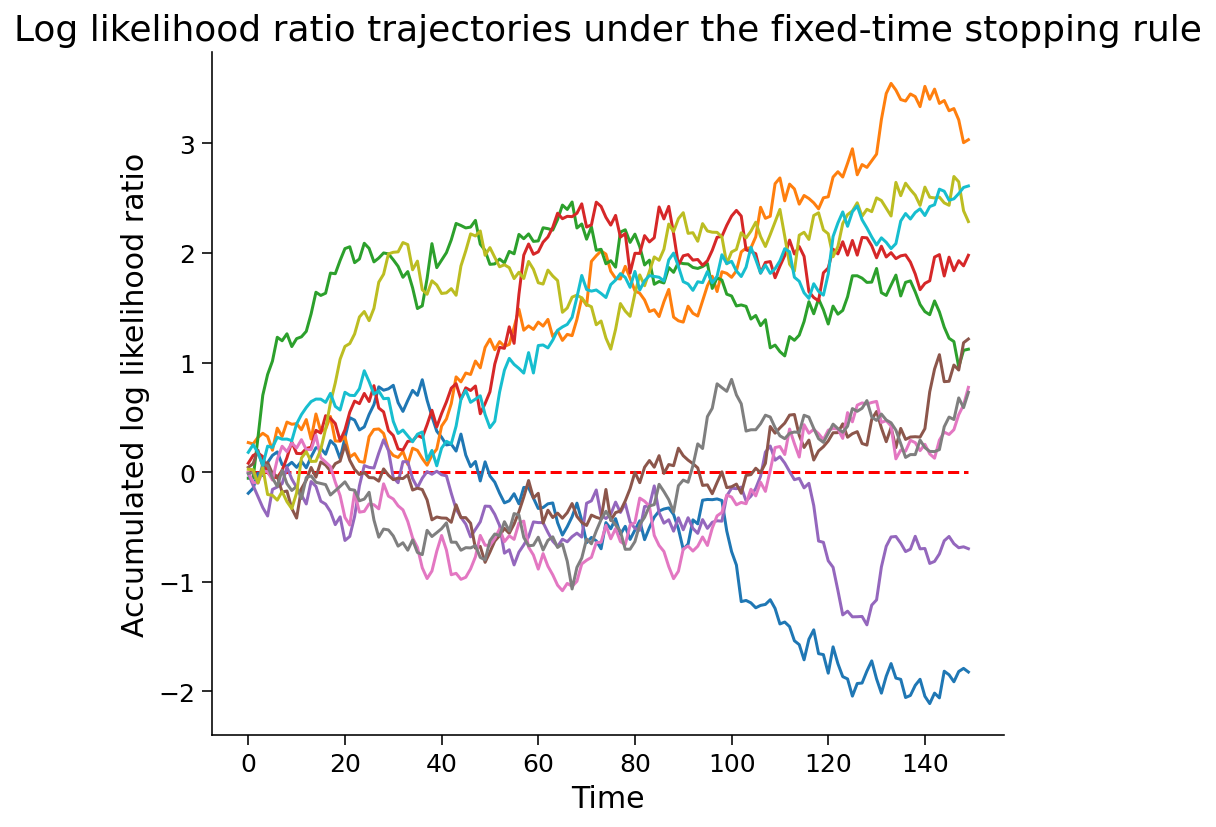

In [ ]:
def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(mu,sigma^2) and
  N(-mu,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """


  # Set means of observation distributions
  assert mu > 0, "Mu should be > 0"
  mu_pos = mu
  mu_neg = -mu

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)


  # Step 1 : Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = p_pos.logpdf(Mvec) - p_neg.logpdf(Mvec)

  # STEP 2: Calculate accumulated evidence given a time series of evidence
  evidence_history = np.cumsum(ll_ratio_vec)

  # Step 3: Make decision based on the sign of the evidence at the final time.
  decision = np.sign(evidence_history[-1])

  return evidence_history, decision, Mvec


# Set random seed
np.random.seed(100)

# Set model parameters
mu = .2
sigma = 3.5  # standard deviation for p+ and p-
num_sample = 10  # number of simulations to run
stop_time = 150 # number of steps before stopping

# Simulate and visualize
simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample)

*Example output:*

<img alt='Solution hint' align='left' width=1145.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial1_Solution_985833af_1.png>



## Interactive Demo: Trajectories under the fixed-time stopping rule


In the following demo, you can change the drift level (mu), noise level (sigma) in the observation model and the number of time steps before stopping (stop_time) using the sliders. You will then observe 10 simulations with those parameters. As in the previous exercise, the true state is +1.

1.   Are you more likely to make the wrong decision (choose the incorrect state) with high or low noise?
2. What happens when sigma is very small? Why?
3.   Are you more likely to make the wrong decision (choose the incorrect state) with fewer or more time steps before stopping?


In [ ]:
# @markdown Make sure you execute this cell to enable the widget!

np.random.seed(100)
num_sample = 10

@widgets.interact(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5), sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1))
def plot(mu, sigma, stop_time):
  simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample, verbose=False)

interactive(children=(FloatSlider(value=0.5, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

##Interpretation

Let's interpret a bit this model. We can write each new evidence ($\Delta_t$, the log likelihood ratio for the measurement at time $t$) as

$$\Delta_t=b+c\epsilon_t$$

If the true state is $s=+1$, the first term $b$ is a constant value and equals $b=2\mu^2/\sigma^2$ (if $s = -1$, $b=-2\mu^2/\sigma^2$). This term favors the actual hidden state. The second term, $c\epsilon_t$ where $\epsilon_t\sim\mathcal{N}(0,1)$, is a standard random variable which is scaled by the diffusion $c=2\mu/\sigma$.

The accumulation of evidence will thus "drift" toward one outcome, while "diffusing" in random directions, hence the term "drift-diffusion model" (DDM). The process is most likely (but not guaranteed) to reach the correct outcome eventually.

As a bonus exercise, try to recover this result using the definition of the log likelihood and the definition of the gaussian distribution. 


## Summary

Good job! By simulating Drift Diffusion Models, you have learnt how to:

* Calculate individual sample evidence as the log likelihood ratio of two candidate models
* Accumulate evidence from new data points, and compute posterior using recursive formula

## Further insights... 

As you probably conclude from the interactive demo, the accuracy of your decision depends on how quickly you have to make that decision. It is then also interesting to analyze the speed-accuracy trade-off of your model. The speed-accuracy trade-off is typically the kind of experimental data that are useful to set your model parameters. 

Other stopping rules exist. For example, instead of making your decision after a fixed number of sample, you could set some thresholds (one for decision A, one for decision B). Once your evidence goes beyond one or the other threshold, your decision is made.  

This tutorial is simply to provide an intuition about the DMM, more details will be introduced in LGBIO2072 (Mathematical models in neurosciences) if you are interested.